In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2022-05-09 22:54:59


In [2]:
import seaborn as sns
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.efficiency_measures import global_efficiency
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.quality import performance

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [4]:
dirs = 'Outputs'
if not os.path.exists(dirs):
    os.makedirs(dirs)

# Part 1: Topological network

In [5]:
G = nx.read_graphml('london.graph.xml')

In [6]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [7]:
# we can also add the stations name to the edge attributes from the nodes attributes:

nod_name1={(e1,e2):(G.nodes[e1]['coords']) for e1, e2 in G.edges()}
nod_name2={(e1,e2):(G.nodes[e2]['coords']) for e1, e2 in G.edges()}

nx.set_edge_attributes(G,nod_name1,'node_1_')
nx.set_edge_attributes(G,nod_name2,'node_2_')

In [8]:
test = nx.to_pandas_edgelist(G)
test['flows'].mean()

21265.19700214133

In [9]:
nlen = {n:nx.single_source_dijkstra_path_length(G, n, weight='length') for n in G.nodes() }
e = nx.eccentricity(G,sp=nlen)
d = nx.diameter(G, e)
d

78581.28589029584

In [10]:
print(G.number_of_nodes(),G.number_of_edges())

401 467


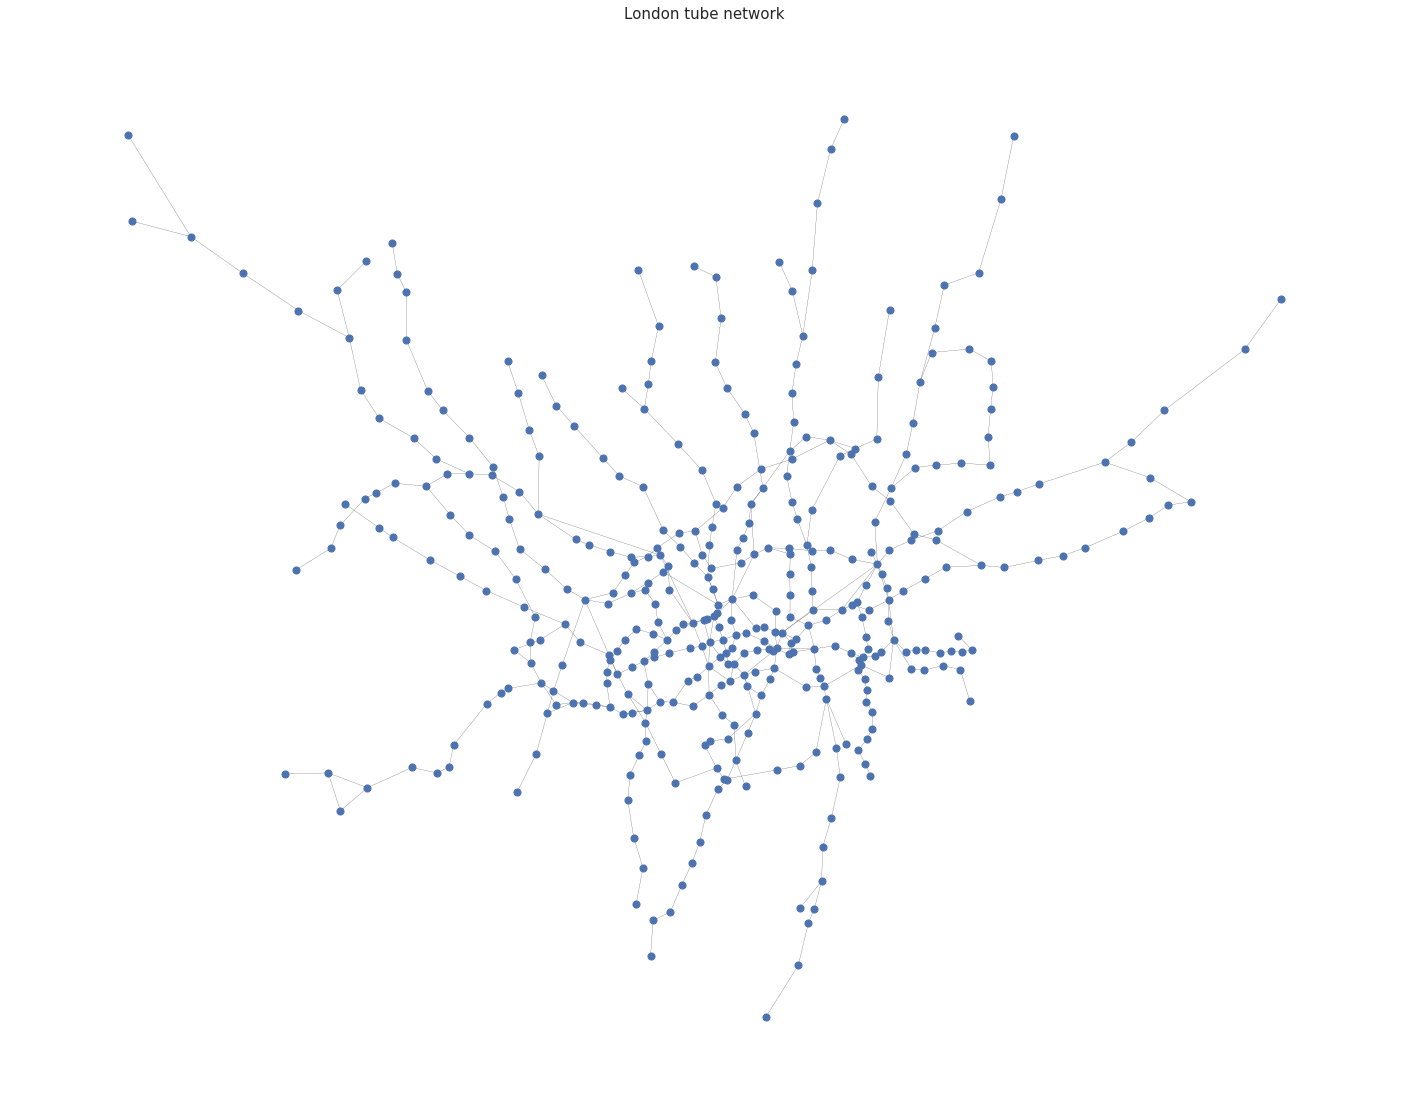

In [11]:
fig, ax = plt.subplots(figsize=(25,20))

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

## Centrality Measures

### Degree  Centrality (DC)

In [12]:
df = pd.DataFrame(index=G.nodes())
deg_topo =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_topo),'DC_topo')
df['DC Topo'] = pd.Series(nx.get_node_attributes(G, 'DC_topo'))
dc_topo = df.sort_values('DC Topo', ascending=False)
dc_topo_sorted = dc_topo[0:10]

### Betweenness Centrality (BC)

In [13]:
df = pd.DataFrame(index=G.nodes())
bet_topo=nx.betweenness_centrality(G, normalized=True)
nx.set_node_attributes(G,bet_topo,'BC_topo')
df['BC Topo'] = pd.Series(nx.get_node_attributes(G, 'BC_topo'))
bc_topo = df.sort_values('BC Topo', ascending=False)
bc_topo_sorted = bc_topo[0:10]
bc_topo_sorted

,BC Topo
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


### Closeness Centrality (CC)

In [14]:
df = pd.DataFrame(index=G.nodes())
clos_topo=nx.closeness_centrality(G)
nx.set_node_attributes(G,clos_topo,'CC_topo')
df['CC Topo'] = pd.Series(nx.get_node_attributes(G, 'CC_topo'))
cc_topo= df.sort_values('CC Topo', ascending=False)
cc_topo_sorted = cc_topo[0:10]


### Rank of Stations Centrality

In [15]:
ranked_topo_all = pd.DataFrame(
    {
        'rank':np.arange(1, 11),
        'DC Nodes':dc_topo_sorted.index.tolist(),
        'DC':dc_topo_sorted['DC Topo'].tolist(),
        'BC Nodes':bc_topo_sorted.index.tolist(),
        'BC':bc_topo_sorted['BC Topo'].tolist(),
        'CC Nodes':cc_topo_sorted.index.tolist(),
        'CC':cc_topo_sorted['CC Topo'].tolist()
    }
)

In [16]:
ranked_topo_all

,rank,DC Nodes,DC,BC Nodes,BC,CC Nodes,CC
0,1,Stratford,0.0225,Stratford,0.297846,Green Park,0.114778
1,2,Bank and Monument,0.0200,Bank and Monument,0.290489,Bank and Monument,0.113572
2,3,King's Cross St. Pancras,0.0175,Liverpool Street,0.270807,King's Cross St. Pancras,0.113443
3,4,Baker Street,0.0175,King's Cross St. Pancras,0.255307,Westminster,0.112549
4,5,Earl's Court,0.0150,Waterloo,0.243921,Waterloo,0.112265
5,6,Oxford Circus,0.0150,Green Park,0.215835,Oxford Circus,0.111204
6,7,Liverpool Street,0.0150,Euston,0.208324,Bond Street,0.110988
7,8,Waterloo,0.0150,Westminster,0.203335,Farringdon,0.110742
8,9,Green Park,0.0150,Baker Street,0.191568,Angel,0.110742
9,10,Canning Town,0.0150,Finchley Road,0.165085,Moorgate,0.110314


In [17]:
ranked_topo_all.to_csv(os.path.join(dirs,'table1.csv'))

## Impact Measures

Three options of impact measures for global network

### Average clustering coefficient

In [18]:
def get_average_cc(g):
    c = nx.clustering(g)
    c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
    c_avg = sum([i[1] for i in c]) / len(c)
    return c_avg

In [19]:
get_average_cc(G)

0.030382377389858668

In [20]:
nx.average_clustering(G)

0.030382377389858693

### Size of Gaint component

In [21]:
s = len(G)
def get_size_gc(g):
    gc = max(nx.connected_components(g), key=len)
    size_gc = len(gc)/s
    return size_gc

### Global Efficiency

In [22]:
global_efficiency(G)

0.1012561935972123

## Node Removal

### Non-sequential Removal 

Using your table in 1.- remove 1 node at a time following the
rank in the table, i.e. from the most important one to the 10th most important one. After each removal,
evaluate the impact of the removal using your two measures in 2.-, and proceed until you have
removed at least 10 nodes. 

Scenario 1-3 (non-sequential DC, BC, CC)

dc_topo_sorted; bc_topo_sorted; cc_topo_sorted

#### **Scenario 1**

Remove first 30 most important node ranked by DC.

In [23]:
# create lists starting with no-removal
list_acc_s1 = [get_average_cc(G)]
list_sgc_s1 = [get_size_gc(G)]
list_ge_s1 = [global_efficiency(G)]
list_nodes_s1 = ['No-removal']
G_s1 = G.copy()
for i in range(10):
    node = dc_topo_sorted.index.tolist()[i]
    list_nodes_s1.append(node)
    G_s1.remove_node(node)
    list_acc_s1.append(get_average_cc(G_s1))
    list_sgc_s1.append(get_size_gc(G_s1))
    list_ge_s1.append(global_efficiency(G_s1))


#### **Scenario 2**

Remove 1-10th most important node ranked by BC.

In [24]:
# create lists starting with no-removal
list_acc_s2 = [get_average_cc(G)]
list_sgc_s2 = [get_size_gc(G)]
list_ge_s2 = [global_efficiency(G)]
list_nodes_s2 = ['No-removal']
G_s2 = G.copy()
for i in range(10):
    node = bc_topo_sorted.index.tolist()[i]
    list_nodes_s2.append(node)
    G_s2.remove_node(node)
    list_acc_s2.append(get_average_cc(G_s2))
    list_sgc_s2.append(get_size_gc(G_s2))
    list_ge_s2.append(global_efficiency(G_s2))


#### **Scenario 3**

Remove 1-10th most important node ranked by CC.

In [25]:
# create lists starting with no-removal
list_acc_s3 = [get_average_cc(G)]
list_sgc_s3 = [get_size_gc(G)]
list_ge_s3 = [global_efficiency(G)]
list_nodes_s3 = ['No-removal']
G_s3 = G.copy()
for i in range(10):
    node = cc_topo_sorted.index.tolist()[i]
    list_nodes_s3.append(node)
    G_s3.remove_node(cc_topo_sorted.index.tolist()[i])
    list_acc_s3.append(get_average_cc(G_s3))
    list_sgc_s3.append(get_size_gc(G_s3))
    list_ge_s3.append(global_efficiency(G_s3))


### Sequential Removal

Remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least two nodes.

Scenario 4-6 (sequential DC, BC, CC)

dc_topo_sorted_i; bc_topo_sorted_i; cc_topo_sorted_i

#### **Scenario 4**

Rank by DC, remove the 1st, re-compute centrality measure, rank by BC and remove the 1st again. Repeat 10 times.

In [26]:
G_s4 = G.copy()

In [27]:
# create lists starting with no-removal
list_acc_s4 = [get_average_cc(G)]
list_sgc_s4 = [get_size_gc(G)]
list_ge_s4 = [global_efficiency(G)]
list_nodes_s4 = ['No-removal']
list_tempo_node_s4 = []
list_tempo_dc_s4 = []
for i in range(10):
    tempo_deg_topo=nx.degree_centrality(G_s4)
    tempo_deg_topo_df=pd.DataFrame.from_dict(dict(tempo_deg_topo),columns=['DC'],orient='index')
    tempo_node_dc = tempo_deg_topo_df.sort_values('DC', ascending=False).index[0]
    list_nodes_s4.append(tempo_node_dc)
    tempo_dc = tempo_deg_topo_df.sort_values(["DC"], ascending=False)["DC"][0]
    print(i+1, tempo_node_dc, tempo_dc)
    list_tempo_node_s4.append(tempo_node_dc)
    list_tempo_dc_s4.append(tempo_dc)
    G_s4.remove_node(tempo_node_dc)
    list_acc_s4.append(get_average_cc(G_s4))
    list_sgc_s4.append(get_size_gc(G_s4))
    list_ge_s4.append(global_efficiency(G_s4))

1 Stratford 0.0225
2 Bank and Monument 0.020050125313283207
3 Baker Street 0.017587939698492462
4 King's Cross St. Pancras 0.017632241813602016
5 Earl's Court 0.015151515151515152
6 Green Park 0.01518987341772152
7 Canning Town 0.015228426395939085
8 Willesden Junction 0.012722646310432571
9 Turnham Green 0.012755102040816325
10 Oxford Circus 0.012787723785166242


#### **Scenario 5**

Rank by BC, remove the 1st, re-compute centrality measure, rank by BC and remove the 1st again. Repeat 10 times.

In [28]:
G_s5 = G.copy()

In [29]:
# create lists starting with no-removal
list_acc_s5 = [get_average_cc(G)]
list_sgc_s5 = [get_size_gc(G)]
list_ge_s5 = [global_efficiency(G)]
list_nodes_s5 = ['No-removal']
list_tempo_node_s5 = []
list_tempo_bc_s5 = []
for i in range(10):
    tempo_bet_topo=nx.betweenness_centrality(G_s5, normalized=True)
    tempo_bet_topo_df=pd.DataFrame.from_dict(dict(tempo_bet_topo),columns=['BC'],orient='index')
    tempo_node_bc = tempo_bet_topo_df.sort_values('BC', ascending=False).index[0]
    list_nodes_s5.append(tempo_node_bc)
    tempo_bc = tempo_bet_topo_df.sort_values(["BC"], ascending=False)["BC"][0]
    print(i+1, tempo_node_bc, tempo_bc)
    list_tempo_node_s5.append(tempo_node_bc)
    list_tempo_bc_s5.append(tempo_bc)
    G_s5.remove_node(tempo_node_bc)
    list_acc_s5.append(get_average_cc(G_s5))
    list_sgc_s5.append(get_size_gc(G_s5))
    list_ge_s5.append(global_efficiency(G_s5))

1 Stratford 0.2978457823852558
2 King's Cross St. Pancras 0.2472624217551865
3 Waterloo 0.25417997746403626
4 Bank and Monument 0.21465090713621304
5 Canada Water 0.24490271917487122
6 West Hampstead 0.4568311797721293
7 Earl's Court 0.09618165819002801
8 Shepherd's Bush 0.1288521345773255
9 Euston 0.08707516080135841
10 Baker Street 0.09843705598181302


#### **Scenario 6**

Rank by CC, remove the 1st, re-compute centrality measure, rank by CC and remove the 1st again. Repeat 10 times.

In [30]:
G_s6 = G.copy()

In [31]:
# create lists starting with no-removal
list_acc_s6 = [get_average_cc(G)]
list_sgc_s6 = [get_size_gc(G)]
list_ge_s6 = [global_efficiency(G)]
list_nodes_s6 = ['No-removal']
list_tempo_node_s6 = []
list_tempo_cc_s6 = []
for i in range(10):
    tempo_clos_topo=nx.closeness_centrality(G_s6)
    tempo_clos_topo_df=pd.DataFrame.from_dict(dict(tempo_clos_topo),columns=['CC'],orient='index')
    tempo_node_cc = tempo_clos_topo_df.sort_values('CC', ascending=False).index[0]
    list_nodes_s6.append(tempo_node_cc)
    tempo_dc = tempo_clos_topo_df.sort_values(["CC"], ascending=False)["CC"][0]
    print(i+1, tempo_node_cc, tempo_dc)
    list_tempo_node_s6.append(tempo_node_cc)
    list_tempo_cc_s6.append(tempo_dc)
    G_s6.remove_node(tempo_node_cc)
    list_acc_s6.append(get_average_cc(G_s6))
    list_sgc_s6.append(get_size_gc(G_s6))
    list_ge_s6.append(global_efficiency(G_s6))

1 Green Park 0.11477761836441894
2 King's Cross St. Pancras 0.11236271472824556
3 Waterloo 0.1046542203523534
4 Bank and Monument 0.09742331288343559
5 West Hampstead 0.08173374613003095
6 Canada Water 0.07597614925947298
7 Stratford 0.0637317773723287
8 Earl's Court 0.06364466101439217
9 Shepherd's Bush 0.06043437204910292
10 Oxford Circus 0.05050144516038999


In [32]:
seq_topo_all = pd.DataFrame(
    {
        'Order':np.arange(1, 11),
        'DC Seq':list_tempo_node_s4,
        'DC':list_tempo_dc_s4,
        'BC Seq':list_tempo_node_s5,
        'BC':list_tempo_bc_s5,
        'CC Seq':list_tempo_node_s6,
        'CC':list_tempo_cc_s6
    }
)

In [33]:
seq_topo_all

,Order,DC Seq,DC,BC Seq,BC,CC Seq,CC
0,1,Stratford,0.022500,Stratford,0.297846,Green Park,0.114778
1,2,Bank and Monument,0.020050,King's Cross St. Pancras,0.247262,King's Cross St. Pancras,0.112363
2,3,Baker Street,0.017588,Waterloo,0.254180,Waterloo,0.104654
3,4,King's Cross St. Pancras,0.017632,Bank and Monument,0.214651,Bank and Monument,0.097423
4,5,Earl's Court,0.015152,Canada Water,0.244903,West Hampstead,0.081734
5,6,Green Park,0.015190,West Hampstead,0.456831,Canada Water,0.075976
6,7,Canning Town,0.015228,Earl's Court,0.096182,Stratford,0.063732
7,8,Willesden Junction,0.012723,Shepherd's Bush,0.128852,Earl's Court,0.063645
8,9,Turnham Green,0.012755,Euston,0.087075,Shepherd's Bush,0.060434
9,10,Oxford Circus,0.012788,Baker Street,0.098437,Oxford Circus,0.050501


In [34]:
seq_topo_all.to_csv(os.path.join(dirs,'table2.csv'))

### Result plotting

In [35]:
list_nodes = [list_nodes_s1,list_nodes_s2,list_nodes_s3,list_nodes_s4,list_nodes_s5,list_nodes_s6]
list_acc = [list_acc_s1,list_acc_s2,list_acc_s3,list_acc_s4,list_acc_s5,list_acc_s6]
list_sgc = [list_sgc_s1,list_sgc_s2,list_sgc_s3,list_sgc_s4,list_sgc_s5,list_sgc_s6]
list_ge = [list_ge_s1,list_ge_s2,list_ge_s3,list_ge_s4,list_ge_s5,list_ge_s6]
list_centra_measures = ['DC','BC','CC','DC','BC','CC']
list_strategy = ['non-seq','non-seq','non-seq','seq','seq','seq']
list_df = []
for i in range(6):
    tempo_df = pd.DataFrame({
        'Node_to_remove':list_nodes[i],
        'Average_cc':list_acc[i],
        'Size_gc':list_sgc[i],
        'Global_efficiency':list_ge[i],
        'Scenario':'Scenario_'+str(i+1),
        'Measure':list_centra_measures[i],
        'Strategy':list_strategy[i]
    })
    list_df.append(tempo_df)
nodes_removal_df = pd.concat(list_df).reset_index()

In [36]:
nodes_removal_df.sample(5, random_state=42)

,index,Node_to_remove,Average_cc,Size_gc,Global_efficiency,Scenario,Measure,Strategy
54,10,Baker Street,0.016283,0.423940,0.038164,Scenario_5,BC,seq
62,7,Stratford,0.028378,0.563591,0.051884,Scenario_6,CC,seq
0,0,No-removal,0.030382,1.000000,0.101256,Scenario_1,DC,non-seq
45,1,Stratford,0.030625,0.945137,0.088917,Scenario_5,BC,seq
5,5,Earl's Court,0.020539,0.930175,0.074036,Scenario_1,DC,non-seq


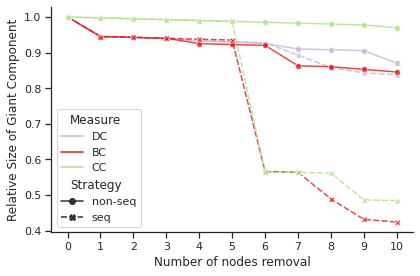

In [37]:
ax = sns.lineplot(data=nodes_removal_df,
                  x="index", y="Size_gc",
                  hue="Measure", style="Strategy",
                  markers=True, dashes=True,
                  palette = 'Paired_r',
                  alpha = 0.8)
plt.xticks(np.arange(11))
ax.set(xlabel = 'Number of nodes removal',
       ylabel = 'Relative Size of Giant Component')
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P1_topo_sgc.jpg'), dpi = 300)


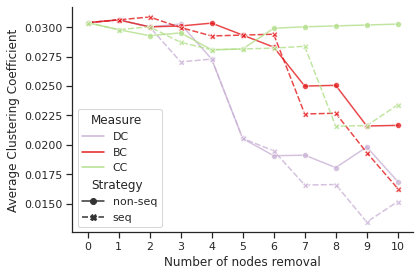

In [38]:
ax = sns.lineplot(data=nodes_removal_df,
                  x="index", y="Average_cc",
                  hue="Measure", style="Strategy",
                  markers=True, dashes=True,
                  palette = 'Paired_r',
                  alpha = 0.8)
plt.xticks(np.arange(11))
ax.set(xlabel = 'Number of nodes removal',
       ylabel = 'Average Clustering Coefficient')
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P1_topo_acc.jpg'), dpi = 300)


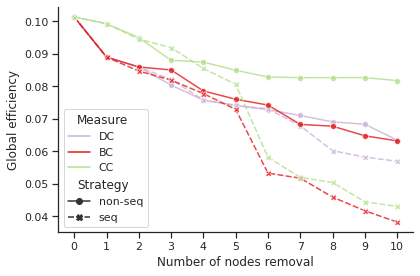

In [39]:
ax = sns.lineplot(data=nodes_removal_df,
                  x="index", y="Global_efficiency",
                  hue="Measure", style="Strategy",
                  markers=True, dashes=True,
                  palette = 'Paired_r',
                  alpha = 0.8)
plt.xticks(np.arange(11))
ax.set(xlabel = 'Number of nodes removal',
       ylabel = 'Global efficiency')
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P1_topo_ge.jpg'), dpi = 300)

The Best performing measure to assess node removal here: **Global Efficiency**.

## Flows: weighted network

## Centrality Measures

### Betweenness Centrality (BC)

In [40]:
df = pd.DataFrame(index=G.nodes())
bet_weighted=nx.betweenness_centrality(G, weight = 'flows', normalized=True)
nx.set_node_attributes(G,bet_weighted,'BC_weighted')
df['BC Weighted'] = pd.Series(nx.get_node_attributes(G, 'BC_weighted'))
bc_weighted = df.sort_values('BC Weighted', ascending=False)
bc_weighted_sorted = bc_weighted[0:10]

In [41]:
bc_weighted_sorted

,BC Weighted
West Hampstead,0.355909
Gospel Oak,0.275025
Finchley Road & Frognal,0.268747
Hampstead Heath,0.267820
Willesden Junction,0.240182
Leicester Square,0.214258
Brondesbury,0.207093
Brondesbury Park,0.205658
Kensal Rise,0.204258
Blackhorse Road,0.201651


In [42]:
ranked_compare = pd.DataFrame(
    {
        'rank':np.arange(1, 11),
        'BC Topo Nodes':bc_topo_sorted.index.tolist(),
        'BC Topo':bc_topo_sorted['BC Topo'].tolist(),
        'BC Weighted Nodes':bc_weighted_sorted.index.tolist(),
        'BC Weighted':bc_weighted_sorted['BC Weighted'].tolist()
    }
)

In [43]:
ranked_compare

,rank,BC Topo Nodes,BC Topo,BC Weighted Nodes,BC Weighted
0,1,Stratford,0.297846,West Hampstead,0.355909
1,2,Bank and Monument,0.290489,Gospel Oak,0.275025
2,3,Liverpool Street,0.270807,Finchley Road & Frognal,0.268747
3,4,King's Cross St. Pancras,0.255307,Hampstead Heath,0.267820
4,5,Waterloo,0.243921,Willesden Junction,0.240182
5,6,Green Park,0.215835,Leicester Square,0.214258
6,7,Euston,0.208324,Brondesbury,0.207093
7,8,Westminster,0.203335,Brondesbury Park,0.205658
8,9,Baker Street,0.191568,Kensal Rise,0.204258
9,10,Finchley Road,0.165085,Blackhorse Road,0.201651


In [45]:
ranked_compare.to_csv(os.path.join(dirs,'table3.csv'))

In [46]:
list_edge_WH_topo = [(u,v) for  u,v,d in G.edges(data=True) if u == bc_weighted_sorted.index.tolist()[0] or v == bc_weighted_sorted.index.tolist()[0] ]
list_edge_WH_topo

[('Finchley Road', 'West Hampstead'),
 ('Kilburn', 'West Hampstead'),
 ('West Hampstead', 'Brondesbury'),
 ('West Hampstead', 'Finchley Road & Frognal')]

In [47]:
list_edge_Stra_topo = [(u,v) for  u,v,d in G.edges(data=True) if u == bc_topo_sorted.index.tolist()[0] or v == bc_topo_sorted.index.tolist()[0] ]
list_edge_Stra_topo

[('Stratford', 'West Ham'),
 ('Stratford', 'Mile End'),
 ('Stratford', 'Leyton'),
 ('Stratford', 'Hackney Wick'),
 ('Stratford', 'Stratford High Street'),
 ('Stratford', 'Pudding Mill Lane'),
 ('Stratford', 'Stratford International'),
 ('Stratford', 'Liverpool Street'),
 ('Stratford', 'Maryland')]

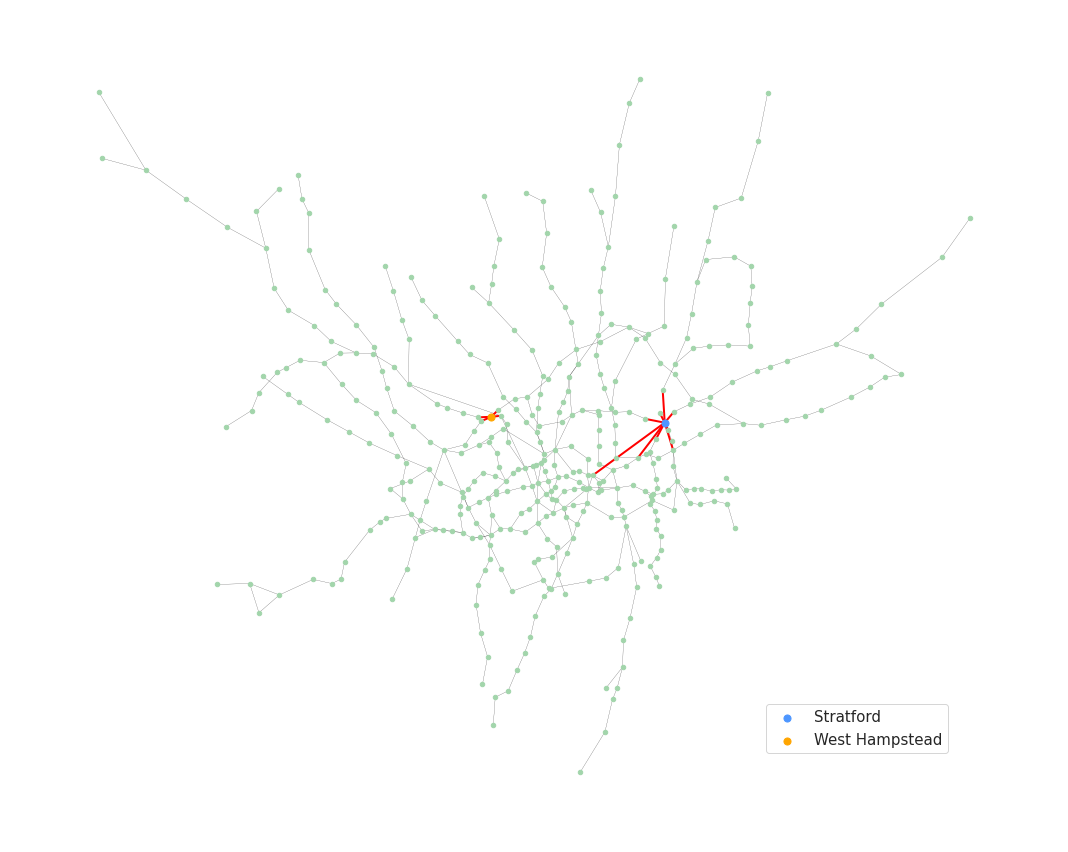

In [48]:
fig, ax = plt.subplots(figsize=(15,12))

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=20,node_color='#A2D5AB')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nod1=nx.draw_networkx_nodes(G, pos = pos, nodelist = [bc_topo_sorted.index.tolist()[0]], node_color= '#4D96FF',label = bc_topo_sorted.index.tolist()[0], node_size=50)
edge1=nx.draw_networkx_edges(G,pos,edgelist=list_edge_Stra_topo,edge_color='red',arrows=False,width=2)
nod2=nx.draw_networkx_nodes(G, pos = pos, nodelist = [bc_weighted_sorted.index.tolist()[0]], node_color= '#ffa500',label = bc_weighted_sorted.index.tolist()[0], node_size=50)
edge2=nx.draw_networkx_edges(G,pos,edgelist=list_edge_WH_topo,edge_color='red',arrows=False,width=2)
plt.legend(loc="lower right",bbox_to_anchor=(0.4, 0.1, 0.5, 0.5),fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P1_II3_Nodes_to_remove.jpg'), dpi = 300)

## Node Removal

[**Functions**](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html?highlight=clustering)

### Old measure: Global Efficiency

According to the [Documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency), the *efficiency* of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. The average global efficiency of a graph is the average efficiency of all pairs of nodes. Edge weights are ignored when computing the shortest path distances.

In [49]:
nx.global_efficiency(G)

0.1012561935972123

In [50]:
G_highest_removed = G.copy()
G_highest_removed.remove_node(bc_topo_sorted.index.tolist()[0])
print('The node removed:',bc_topo_sorted.index.tolist()[0])
print('Global efficiency after node removal:', nx.global_efficiency(G_highest_removed))

The node removed: Stratford
Global efficiency after node removal: 0.08891736066510689


In [51]:
G_highest_removed = G.copy()
G_highest_removed.remove_node(bc_weighted_sorted.index.tolist()[0])
print('The node removed:',bc_weighted_sorted.index.tolist()[0])
print('Global efficiency after node removal:', nx.global_efficiency(G_highest_removed))

The node removed: West Hampstead
Global efficiency after node removal: 0.10005038744672845


### New proposed global measures: Average Shortest Path Length (ASPL)

In [52]:
#nx.average_shortest_path_length(G)

In [53]:
nx.average_shortest_path_length(G,weight='flows')

255693.32300498753

In [54]:
G_highest_removed = G.copy()
G_highest_removed.remove_node(bc_topo_sorted.index.tolist()[0])
# if removing one node leads to graph split, subgraph the largest componet and compute ASPL 
gc = max(nx.connected_components(G_highest_removed))
G_sub = G.subgraph(gc)
print('The node removed:',bc_topo_sorted.index.tolist()[0])
print('Average shortest path length in weighted network after node removal:', nx.average_shortest_path_length(G_sub,weight='flows'))
print('Size of largest connected:', len(G_sub))
nodes_df1 = pd.DataFrame(index=G.nodes()).reset_index()
nodes_df2 = pd.DataFrame(index=G_sub.nodes()).reset_index()
total = pd.concat([nodes_df1,nodes_df2])
total.drop_duplicates(subset=['index'], keep=False, inplace=True)
list_dis_comp = total['index'].tolist()
list_dis_comp.remove('Stratford')
print('Number of stations that disconnected', len(list_dis_comp))

The node removed: Stratford
Average shortest path length in weighted network after node removal: 248601.93230584523
Size of largest connected: 379
Number of stations that disconnected 21


In [55]:
nodes_df1 = pd.DataFrame(index=G.nodes()).reset_index()
nodes_df2 = pd.DataFrame(index=G_sub.nodes()).reset_index()
total = pd.concat([nodes_df1,nodes_df2])
total.drop_duplicates(subset=['index'], keep=False, inplace=True)

In [56]:
list_dis_comp

['Leyton',
 'Leytonstone',
 'Snaresbrook',
 'South Woodford',
 'Woodford',
 'Buckhurst Hill',
 'Loughton',
 'Debden',
 'Theydon Bois',
 'Epping',
 'Wanstead',
 'Redbridge',
 'Gants Hill',
 'Newbury Park',
 'Barkingside',
 'Fairlop',
 'Hainault',
 'Grange Hill',
 'Chigwell',
 'Roding Valley',
 'Stratford International']

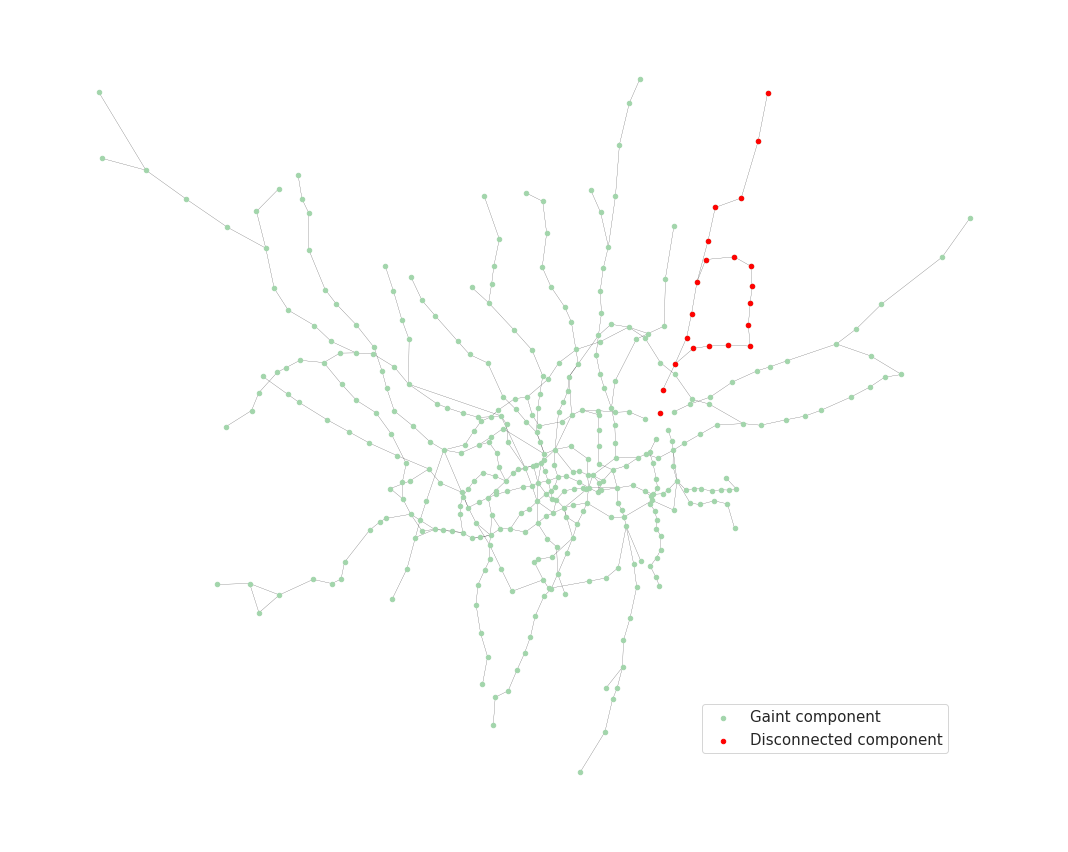

In [57]:
fig, ax = plt.subplots(figsize=(15,12))
pos = nx.get_node_attributes(G_highest_removed, 'coords')
nod1=nx.draw_networkx_nodes(G_highest_removed,pos = pos,node_color= '#A2D5AB',node_size=20, label='Gaint component')
nod2=nx.draw_networkx_nodes(G_highest_removed,pos,node_size=20,nodelist = list_dis_comp, node_color='red',label='Disconnected component')
nx.draw_networkx_edges(G_highest_removed,pos,arrows=False,width=0.2)
plt.legend(loc="lower right",bbox_to_anchor=(0.4, 0.1, 0.5, 0.5),fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(dirs,'P1_II3_Split_Graphs.jpg'), dpi = 300)

In [58]:
G_highest_removed = G.copy()
G_highest_removed.remove_node(bc_weighted_sorted.index.tolist()[0])
print('The node removed:',bc_weighted_sorted.index.tolist()[0])
print('Average shortest path length in weighted network after node removal:', nx.average_shortest_path_length(G_highest_removed,weight='flows'))

The node removed: West Hampstead
Average shortest path length in weighted network after node removal: 287413.5063408521
